<a href="https://colab.research.google.com/github/sugiyama404/ReinfoceLearningForTrading/blob/main/simple_rl_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
from google.colab import drive

from datetime import datetime
from matplotlib import pyplot as plt

drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/reinforcement_learning/'
nov_path = '/content/drive/My Drive/' + nov_dir + 'data_csv_sp500.csv'

df = pd.read_csv(nov_path)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
class Environment:
    def __init__(self, df, initial_money=1000):

        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_money = initial_money
        self.action_space = np.array([0, 1, 2])
        self.stock_owned = None
        self.current_price = None
        self.cash_in_hand = None

        self.reset()
        
    def reset(self):

        self.end_step = self.df_total_steps
        self.current_step = 0
        self.stock_owned = 0.0
        self.current_price = self.df.loc[self.current_step, 'SP500']
        self.cash_in_hand = self.initial_money

        return self._get_now_state()

    def step(self, action):

        self.current_step += 1
        self.current_price = self.df.loc[self.current_step, 'SP500']
 
        # 含み益
        prev_val = self._get_val()

        done = (self.end_step == self.current_step)

        self._trade(action,done)
        cur_val = self._get_val()
        reward = cur_val - prev_val
        info = {'cur_val': cur_val}

        return self._get_now_state(), reward, done, info


    def _get_now_state(self):
        state = np.empty(3)
        state[0] = self.stock_owned
        state[1] = self.current_price
        state[2] = self.cash_in_hand
        return state

    def _get_val(self):
        return self.stock_owned * self.current_price + self.cash_in_hand

    def _trade(self, action,lastorder = False):
        '''
        0 = sell
        1 = hold
        2 = buy
        売りたい株を売る
        買いたい銘柄を買う
        売買ルール：
        1.空売りは認めない
        2.ポジションを持っている場合、追加注文を出せない。
        3.トレーニング期間は最後のステップでポジションを全て売却する。
        '''
        if lastorder:
            self.cash_in_hand += self.current_price * self.stock_owned
            self.stock_owned = 0
        else:
            if self.action_space[0] == action: # sell
            # 注：問題を簡単にするために、売るときはその株のすべての株を売ることにします
                self.cash_in_hand += self.current_price * self.stock_owned
                self.stock_owned = 0
            if self.action_space[2] == action: # buy
            # 注：購入時には、買いたい銘柄をループさせて、現金がなくなるまで1株ずつ購入していきます。
                can_buy = True
                while can_buy:
                    if self.cash_in_hand > self.current_price:
                        self.stock_owned += 1 # buy one share
                        self.cash_in_hand -= self.current_price
                    else:
                        can_buy = False

In [3]:
def play_episode(env, train_episodes = 50):
    list2 = []
    for episode in range(train_episodes):
        state = env.reset()
        done = False
        t0 = datetime.now()
       
        while not done:
            #乱数で1,2,3を出力
            # action = agent.act(state)
            action = np.random.randint(3, size=1)[0]
            state, reward, done,info = env.step(action)

            '''
            next_state : [2420. 15.27 8.40000001] : [持っている株数 今の株価 手持ちのキャッシュ]
            reward : 335.60999999999876
            done : False
            info: {'cur_val': 15667.53000000051}
            '''
            
        list2.append(info['cur_val'])
        dt = datetime.now() - t0
        print(f"episode: {episode + 1}/{train_episodes}, episode end value: {info['cur_val']:.2f}, duration: {dt}")
    return list2

episode: 1/10, episode end value: 35403.70, duration: 0:00:00.080408
episode: 2/10, episode end value: 11911.66, duration: 0:00:00.100161
episode: 3/10, episode end value: 64383.33, duration: 0:00:00.090302
episode: 4/10, episode end value: 11717.14, duration: 0:00:00.126094
episode: 5/10, episode end value: 93663.16, duration: 0:00:00.116826
episode: 6/10, episode end value: 18963.90, duration: 0:00:00.154635
episode: 7/10, episode end value: 44312.18, duration: 0:00:00.143970
episode: 8/10, episode end value: 3450.10, duration: 0:00:00.090286
episode: 9/10, episode end value: 58466.24, duration: 0:00:00.121112
episode: 10/10, episode end value: 46961.08, duration: 0:00:00.137037


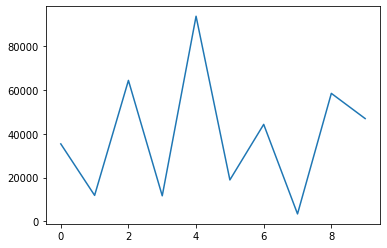

In [4]:
env = Environment(df, initial_money=1000)
#play_episode(env, train_episodes = 10)
list2 = play_episode(env, train_episodes = 10)


x = list(range(10))
y = list2
plt.plot(x, y)
plt.show()